## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import random
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

from collections import Counter
from scipy import stats

# Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors=5, algorithm='brute',
                 p=2, metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.p = p
        self.metric = metric
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.train = np.asarray(X)
            self.targets = np.asarray(y)
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
            self.targets = np.asarray(y)
    
    def predict(self, X):
        prediction = []
        
        if self.algorithm == 'brute':
            for i in range(len(X)):
                distances = []

                for j in range(len(self.train)):
                    d = np.sum(np.square(X[i] - self.train[j]))
                    distances.append((d, self.targets[j]))

                distances = sorted(distances)
                neighbors = []
                for item in range(self.n_neighbors):
                    neighbors.append(distances[item][1])
                prediction.append(stats.mode(neighbors)[0][0])
        
        elif self.algorithm == 'kd_tree':
            for i in range(len(X)):
                dist = []
                ind = []
                if X[i].shape != (1, X[i].size):
                    dist, ind = self.tree.query(X[i].reshape(1, -1), k=self.n_neighbors)
                else:
                    dist, ind = self.tree.query(X[i], k=self.n_neighbors)
                neighbors = np.take(self.targets, ind)
                prediction.append(stats.mode(neighbors)[0][0][0])

        return prediction

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
print(sklearn_pred)
my_clf_pred = my_clf.predict(X_test)
print(my_clf_pred)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

[1 1 2 0 1 0 2 2 0 0 0 1 2 2 1]
[1, 1, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 2, 1]


### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 338 µs, sys: 264 µs, total: 602 µs
Wall time: 467 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 6.44 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.13 ms, sys: 0 ns, total: 1.13 ms
Wall time: 875 µs


array([1, 1, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 2, 1])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 9.81 ms, sys: 342 µs, total: 10.2 ms
Wall time: 9.59 ms


[1, 1, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 2, 1]

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 998 µs, sys: 0 ns, total: 998 µs
Wall time: 806 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 201 µs, sys: 0 ns, total: 201 µs
Wall time: 194 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 1.14 ms, sys: 0 ns, total: 1.14 ms
Wall time: 952 µs


array([0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 1.88 ms, sys: 1.43 ms, total: 3.32 ms
Wall time: 2.53 ms


[0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1]

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [79]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [80]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [81]:
Y = np.copy(target)
vectorizer = CountVectorizer(min_df = 0.03, stop_words='english')
X = vectorizer.fit_transform(data)
X = X.toarray()
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validatio

In [82]:
def KFold(k, x, y):
    
    p = np.random.permutation(len(x))
    X = x[p]
    Y = y[p]
    n_split = k

    kfold = []
    for i in range(n_split):

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=i)
        kfold.append(((X_train, y_train), (X_test, y_test)))
        
    return kfold

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [83]:
def find_best_k(knn, kfold):

    error_train = []
    for k in range(1, 11):
        print(k, end=',')
        knn.n_neighbors = k
        cur_error = []
        for i in range(3):
            trn = kfold[i][0][0]
            trn_targ = kfold[i][0][1]
            
            tst = kfold[i][1][0]
            tst_targ = kfold[i][1][1]


            knn.fit(trn, trn_targ)
            y_pred = knn.predict(tst)
            cur_error.append(np.mean(tst_targ != y_pred))

        print("finished")        
        error_train.append(np.mean(cur_error))
        
    return error_train

In [84]:
kfold = KFold(3, X, Y)
knn = MyKNeighborsClassifier(algorithm='kd_tree')
mink_error_train = find_best_k(knn, kfold)
print(mink_error_train)

1,finished
2,finished
3,finished
4,finished
5,finished
6,finished
7,finished
8,finished
9,finished
10,finished
[0.8112836993394037, 0.8096768434208177, 0.809587573647563, 0.8106588109266202, 0.8093197643277987, 0.8113729691126584, 0.811997857525442, 0.8086948759150152, 0.8103017318336012, 0.8097661131940724]


In [85]:
norm_X = normalize(np.copy(X))
kfold = KFold(3, norm_X, Y)
knn = MyKNeighborsClassifier(algorithm='kd_tree')
cos_error_train = find_best_k(knn, kfold)
print(cos_error_train)

1,finished
2,finished
3,finished
4,finished
5,finished
6,finished
7,finished
8,finished
9,finished
10,finished
[0.7906623817175505, 0.7906623817175505, 0.7899482235315123, 0.7923585074093911, 0.7907516514908052, 0.7875379396536334, 0.787627209426888, 0.7902160328512765, 0.7950366006070344, 0.7914658096768434]


In [86]:
tf_idf = TfidfVectorizer(min_df = 0.03, max_df=0.4, stop_words='english')
idf_X = tf_idf.fit_transform(data)
idf_X = idf_X.toarray()
idf_X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.16935226,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [87]:
kfold = KFold(3, idf_X, Y)
knn = MyKNeighborsClassifier(algorithm='kd_tree')
tf_idf_error_train = find_best_k(knn, kfold)
print(tf_idf_error_train)

1,finished
2,finished
3,finished
4,finished
5,finished
6,finished
7,finished
8,finished
9,finished
10,finished
[0.7908409212640599, 0.7939653633279771, 0.7929833958221746, 0.7920014283163721, 0.7947687912872702, 0.7909301910373148, 0.7930726655954293, 0.7926263167291555, 0.7928941260489198, 0.7915550794500983]


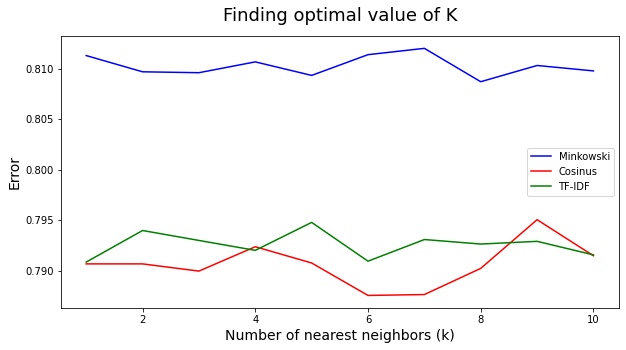

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), mink_error_train, color='b', label="Minkowski")
plt.plot(range(1, 11), cos_error_train, color='r', label="Cosinus")
plt.plot(range(1, 11), tf_idf_error_train, color='g', label="TF-IDF")
plt.xlabel('Number of nearest neighbors (k)', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Finding optimal value of K', fontsize=18, pad=15)
plt.legend()
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [89]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [ ]:
test_data = newsgroups['data']
test_target = newsgroups['target']
test_data = vectorizer.transform(test_data).toarray()
knn = MyKNeighborsClassifier(n_neighbors=4, algorithm='kd_tree')
knn.fit(X, Y)
prediction = knn.predict(test_data)

In [ ]:
print(np.mean(prediction != test_target))

Качество отличается из-за проблемы переобучения модели.